In [215]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as col
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator
import scipy.stats
import matplotlib.gridspec as gridspec

%matplotlib inline

In [216]:
# font size and style
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

cm = 'rainbow'
s  = 50  # marker size

In [231]:
# load data from Petrovic 2003 Fig 12
path  ='./input_files/'
file1 = path + 'Petrovic03_Fig12.dat'

var   = ['rho', 'K_c', 'type']
tab1  = pd.read_csv(file1, delimiter = ',', names=var, header=0, dtype={0:'float',1:'float',2:'str'}) 
# distinguish between snow and ice data points
rho_i    = 917.
rho_snow = tab1['rho'][(i==' S' for i in tab1['type'])]
K_c_snow = tab1['K_c'][(i==' S' for i in tab1['type'])]
rho_ice  = tab1['rho'][(i==' I' for i in tab1['type'])]
K_c_ice  = tab1['K_c'][(i==' I' for i in tab1['type'])]

In [232]:
# define the exponential function
def model_func(x, a, k, b):
    return a * np.exp(k*x) + b

def model_linearized(x, B, C):
    return B * x + C

In [233]:
# linearized curve fit 
x  = np.linspace(10.,1000.,101)   # density range

opt, pcov = curve_fit(model_linearized, np.log(rho_snow / rho_i), np.log(K_c_snow) )
B, C      = opt
y_lin     = np.exp(C) * (x/rho_i)**B
r, p      = scipy.stats.pearsonr(rho_snow, K_c_snow)

opt2, pcov2 = curve_fit(model_linearized, np.log(tab1['rho'] / rho_i), np.log(tab1['K_c']) )
B2, C2      = opt2
y_lin2      = np.exp(C2) * (x/rho_i)**B2
r2, p2      = scipy.stats.pearsonr(tab1['rho'], tab1['K_c'])


# Kirchner 2000: K_c 7.84 (rho_snow / rho_ice)**(2/3)
kirchner = 7.84 * (x / rho_i)**(2.3)

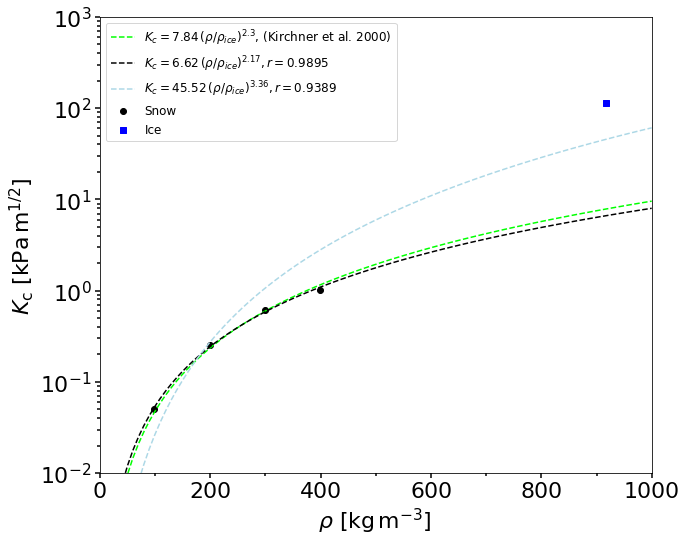

In [250]:
pp = PdfPages('./PDFs/petrovic_fit_and_COR.pdf')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,8])
ax = plt.subplot(1, 1, 1)
plt.yscale('log')
plt.xlabel('$\\rho \ [\mathrm{kg\,m}^{-3}]$ ')
plt.ylabel('$K_\mathrm{c} \ [\mathrm{kPa\,m}^{1/2}]$')
plt.xlim(0,1000)
plt.ylim(0.01,1000)

plt.scatter(rho_snow, K_c_snow, c ='black',  label='Snow')
plt.scatter(rho_ice,  K_c_ice,  c ='blue',   label='Ice', marker='s')
#plt.plot(x,y, c='gray',      linestyle='--', label=r'$K_c = %.2f \, e^{%.5f \rho} %+.2f$, r = %.4f' % (a,k,b,r))
#plt.plot(x,y2,c='lightblue', linestyle='--', label=r'$K_c = %.2f \, e^{%.5f \rho} %+.2f$, r = %.4f' % (a2,k2,b2,r2))
plt.plot(x,kirchner, c='lime',      linestyle='--', label=r'$K_c = 7.84 \, (\rho/\rho_{ice})^{2.3}$, (Kirchner et al. 2000)')
plt.plot(x,y_lin,c='black', linestyle='--', label=r'$K_c = %.2f \, (\rho/\rho_{ice})^{%4.2f}, r = %.4f$' % (np.exp(C),B,r))
plt.plot(x,y_lin2,c='lightblue', linestyle='--', label=r'$K_c = %.2f \, (\rho/\rho_{ice})^{%4.2f}, r = %.4f$' % (np.exp(C2),B2,r2))


ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis='both', which='major', length=5, width=1.5)
ax.tick_params(axis='both', which='minor', length=3, width=1.5)
plt.legend(fontsize=12)
fig.tight_layout()
pp.savefig()

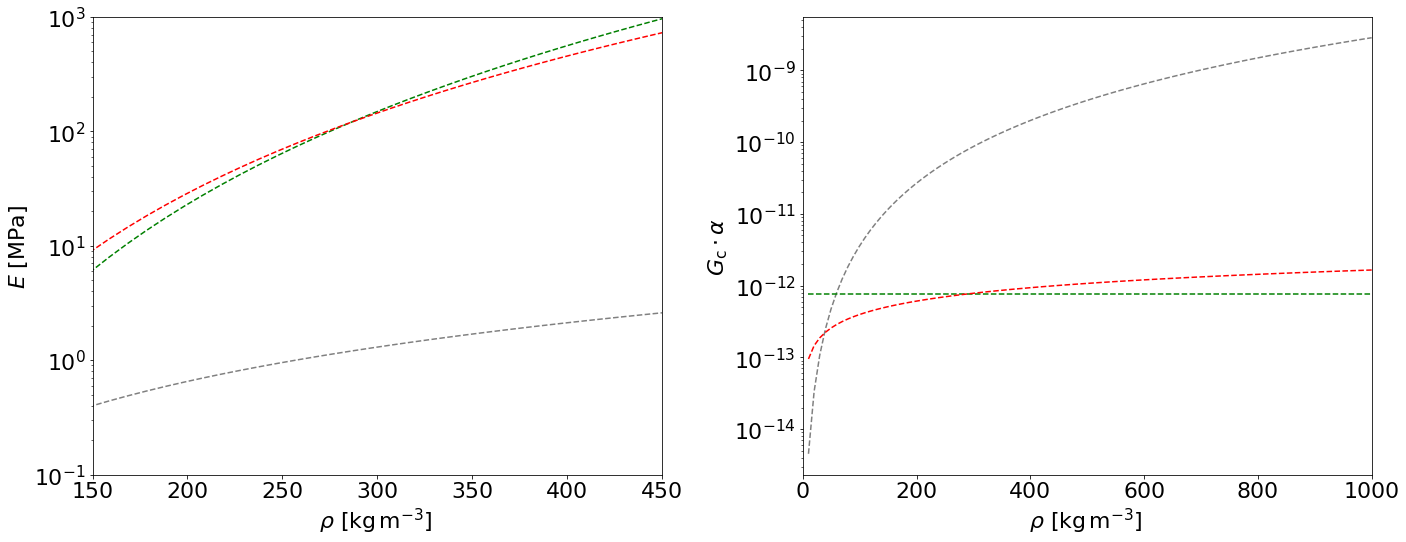

In [251]:
E      = 8e-5  * x**(1.7)
c33_AC = 6e-10 * x**(4.6)
c33_CT = 2e-8 * x**(3.98)
alpha  = 1e-5**2 * np.pi
# energy = K_c**2 / E * alpha with alpha = cross-sectional area of an asperity
y   = ( (7.84 * (x / 917.)**(2.3) )**2 * alpha / E )
yac = ( (7.84 * (x / 917.)**(2.3) )**2 * alpha / c33_AC )
yct = ( (7.84 * (x / 917.)**(2.3) )**2 * alpha / c33_CT )

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,8])
ax = plt.subplot(1, 2, 1)
plt.xlabel('$\\rho \ [\mathrm{kg\,m}^{-3}]$ ')
plt.ylabel('$E$ [MPa]')
plt.yscale('log')
plt.xlim(150,450)
plt.ylim(1e-1,1e3)
plt.plot(x, E, c='gray', linestyle='--')
plt.plot(x, c33_AC, c='green', linestyle='--')
plt.plot(x, c33_CT, c='red', linestyle='--')

ax = plt.subplot(1, 2,2)
plt.xlabel('$\\rho \ [\mathrm{kg\,m}^{-3}]$ ')
plt.ylabel('$G_\mathrm{c} \cdot \\alpha$')
plt.yscale('log')
plt.xlim(0,1000)
plt.plot(x, y, c='gray', linestyle='--')
plt.plot(x, yac, c='green', linestyle='--')
plt.plot(x, yct, c='red', linestyle='--')

fig.tight_layout()

In [252]:
r1 = 1e-3
r2 = 1e-5
R  = 1./ (1./r1 + 1/r2)

rho = rho_i
vel = 1.
Sy = np.linspace(5.2e6,15.6e6, 201)
E_dash = 9.38e9 / (1 - 0.33**2)
v = np.linspace(.015,5.1,101)

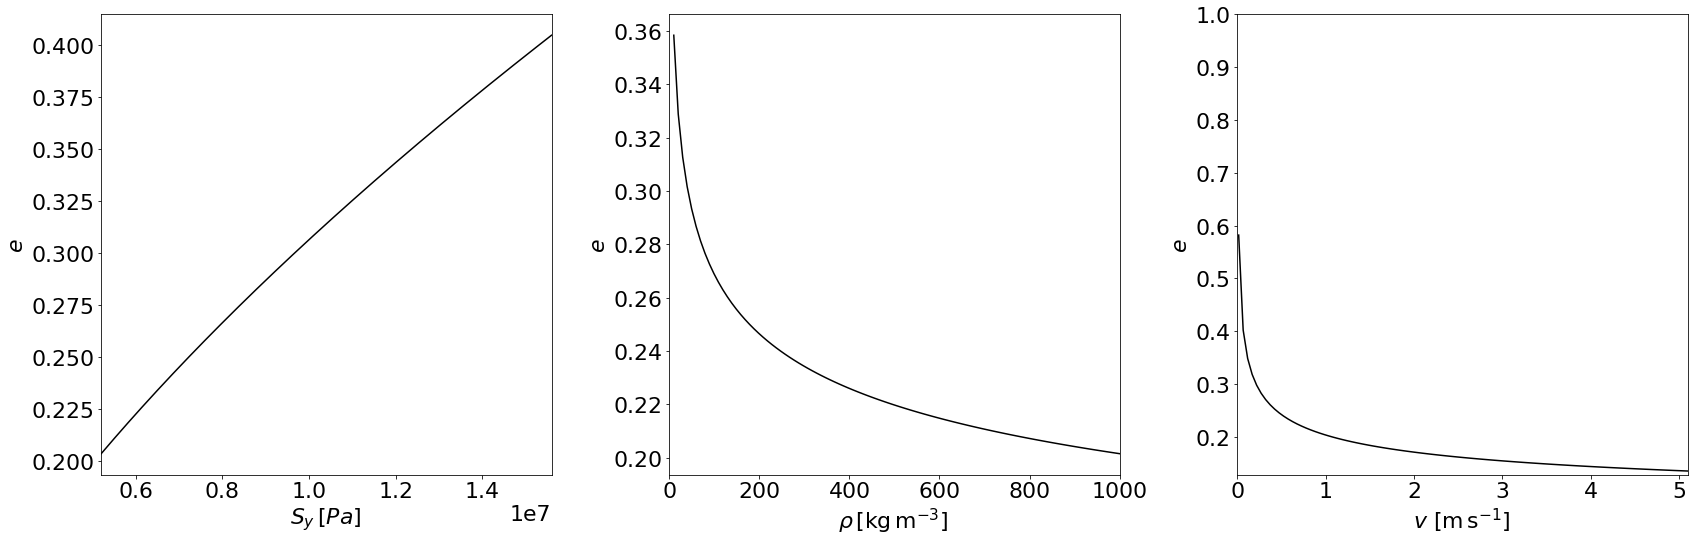

In [253]:
# coefficient of restitution (Jackson et al 2010): 
# e = 3.1 * (Sy / E_dash)**(5/8) * (r2/R)**(3/8) * (np.sqrt(E_dash/rho) * (1 / vel) )**(1/4)
ncol = 3
fig, ax = plt.subplots(nrows=1, ncols=ncol, figsize=[8*ncol,8])
ax = plt.subplot(1, ncol, 1)
plt.xlabel('$S_y \, [Pa]$ ')
plt.ylabel('$e$')
e = 3.1 * (Sy / E_dash)**(5./8.) * (r2/R)**(3./8.) * (np.sqrt(E_dash/rho) * (1 / vel) )**(1./4.)
#plt.ylim(np.amin(e)*.95,1)
plt.xlim(5.2e6,15.6e6)

plt.plot(Sy, e, c='black')

ax = plt.subplot(1, ncol, 2)
plt.xlabel('$\\rho \, [\mathrm{kg\,m}^{-3}]$ ')
plt.ylabel('$e$ ')
e_rho = 3.1 * (5.2e6 / E_dash)**(5./8.) * (r2/R)**(3./8.) * (np.sqrt(E_dash/x) * (1 / vel) )**(1./4.)
#plt.ylim(np.amin(e_rho)*.95,1)
plt.xlim(0,1000.)

plt.plot(x, e_rho, c='black')

ax = plt.subplot(1, ncol, 3)
plt.xlabel('$v \ [\mathrm{m\,s}^{-1}]$ ')
plt.ylabel('$e$ ')
e_v = 3.1 * (5.2e6 / E_dash)**(5./8.) * (r2/R)**(3./8.) * (np.sqrt(E_dash/ rho_i ) * (1 / v) )**(1./4.)
e_bridges= 0.32 * v**(-.234)
plt.ylim(min(np.amin(e_v), np.amin(e_bridges))*.95,1)
plt.xlim(0,5.1)

plt.plot(v, e_v,       c='black')
#plt.plot(v, e_bridges, c='red', linestyle='--', label='Bridges 84')

fig.tight_layout()
pp.savefig()

In [254]:
e_full =np.zeros((len(x),len(v)))
e_full2=np.zeros((len(x),len(v)))
Sy = 5.2e6
for i in range(len(x)):
    for j in range(len(v)):
        r1 = 1e-3
        r2 = 1e-5
        R  = 1./ (1./r1 + 1/r2)
        e_full[i,j]  = 3.1 * (Sy / E_dash)**(5./8.) * (r2/R)**(3./8.) * (np.sqrt(E_dash/ x[i] ) * (1 / v[j]) )**(1./4.)
        r22= 1e-7
        R  = 1./ (1./r1 + 1/r22)
        e_full2[i,j] = 3.1 * (Sy / E_dash)**(5./8.) * (r22/R)**(3./8.) * (np.sqrt(E_dash/ x[i] ) * (1 / v[j]) )**(1./4.)

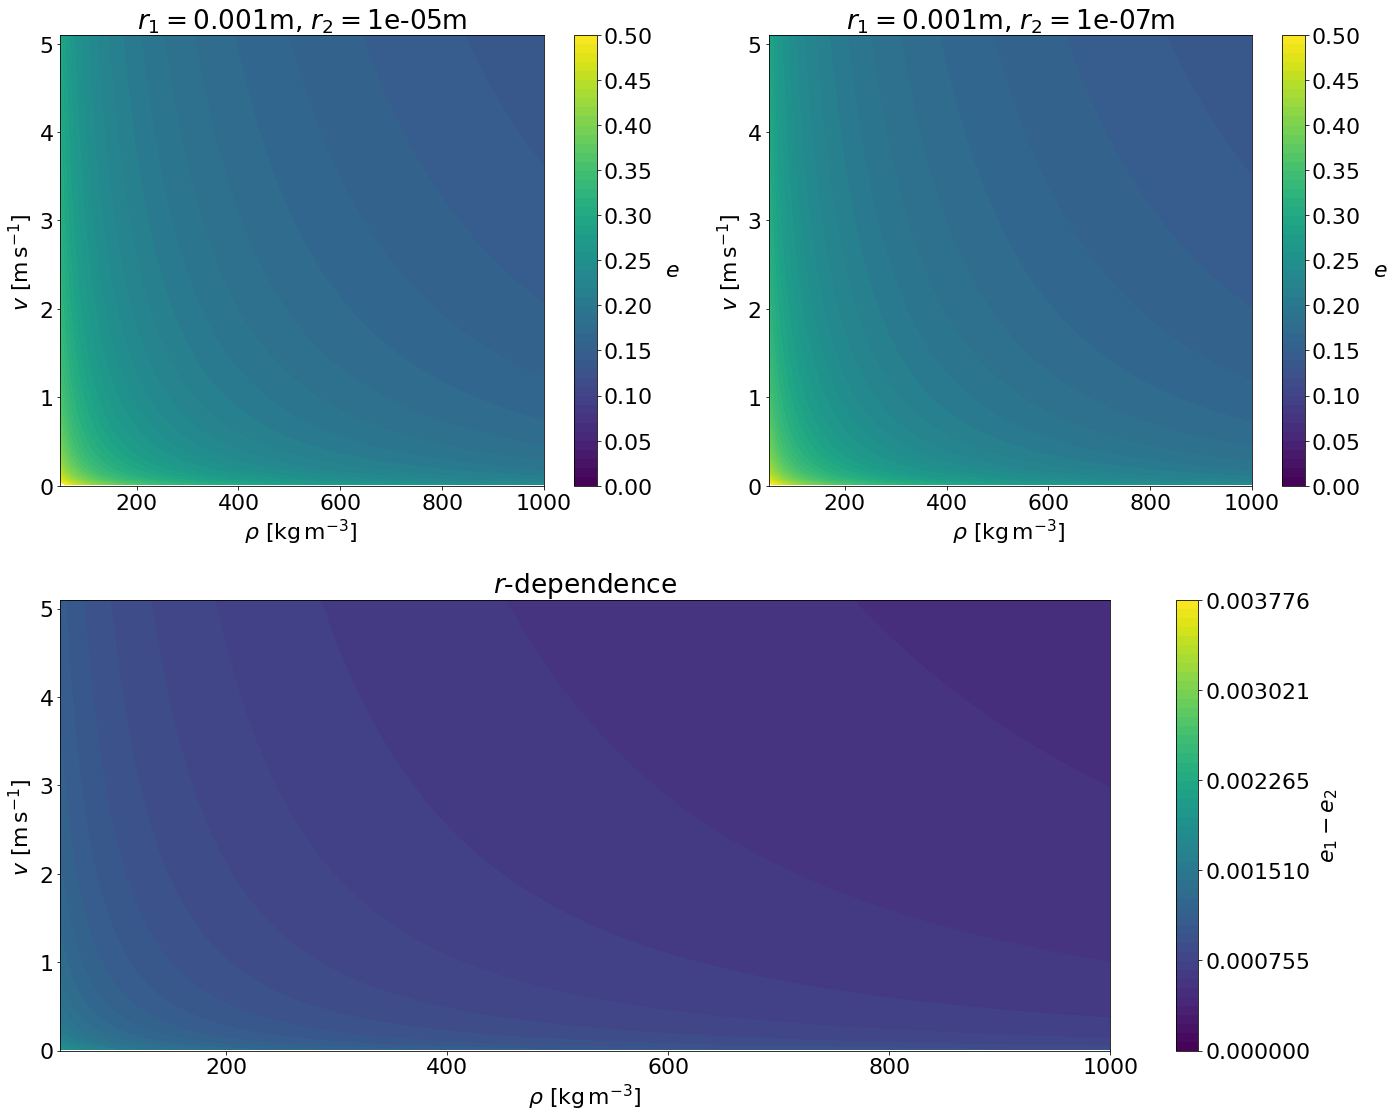

In [255]:
ncols = 2
nrows = 2
tick  = np.linspace(0,.5,11, endpoint=True)
lev   = np.linspace(0,.5,51, endpoint=True)

gs = gridspec.GridSpec(2, 2)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[10*ncols,8*nrows])
ax = plt.subplot(gs[0, 0])
plt.ylabel('$v \ [\mathrm{m\,s}^{-1}]$ ')
plt.xlabel('$\\rho \ [\mathrm{kg\,m}^{-3}]$ ')
plt.ylim(0, 5.1)
plt.xlim(50,1000)
plt.title('$r_1=$'+str(r1)+'m, $r_2=$'+ str(r2) +'m' )

plt.contourf(x,v,e_full,levels=lev)
cbar=plt.colorbar(ticks=tick)
cbar.set_label('$e$',rotation=0, labelpad=20)

ax = plt.subplot(gs[0, 1])
plt.ylabel('$v \ [\mathrm{m\,s}^{-1}]$ ')
plt.xlabel('$\\rho \ [\mathrm{kg\,m}^{-3}]$ ')
plt.ylim(0, 5.1)
plt.xlim(50,1000)

plt.title('$r_1=$'+str(r1)+'m, $r_2=$'+ str(r22) +'m' )
plt.contourf(x,v,e_full2,levels=lev)
cbar=plt.colorbar(ticks=tick)
cbar.set_label('$e$',rotation=0, labelpad=20)

ax = plt.subplot(gs[1, :])
plt.ylabel('$v \ [\mathrm{m\,s}^{-1}]$ ')
plt.xlabel('$\\rho \ [\mathrm{kg\,m}^{-3}]$ ')
plt.ylim(0, 5.1)
plt.xlim(50,1000)

lev=np.linspace(0,np.amax(e_full-e_full2),51, endpoint=True)
plt.title('$r$-dependence')
plt.contourf(x,v,e_full-e_full2, levels=lev)
cbar=plt.colorbar(ticks=np.linspace(0,np.amax(e_full-e_full2),6, endpoint=True))
cbar.set_label('$e_1-e_2$',rotation=90, labelpad=10)

fig.tight_layout()
pp.savefig()

In [256]:
pp.close()

In [248]:
# curve fit
p0 = (1.,1.e-5,1.)               # starting search coeffs
x  = np.linspace(10.,1000.,101)   # density range

opt, pcov = curve_fit(model_func, rho_snow, K_c_snow, p0)
a, k, b   = opt

opt2, pcov2 = curve_fit(model_func, tab1['rho'], tab1['K_c'], p0)
a2,k2,b2    = opt2

y      = model_func(x, a, k, b)
r, p   = scipy.stats.pearsonr(rho_snow, K_c_snow)
y2     = model_func(x, a2, k2, b2)
r2, p2 = scipy.stats.pearsonr(tab1['rho'], tab1['K_c'])